<a href="https://colab.research.google.com/github/shu-nya/Image-Classification-of-White-Blood-Cells/blob/master/Classification_of_WBC_Augmentation_documented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the libraries

In [ ]:
# importing the necessary libraries

import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
from collections import Counter

from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Mount google drive to load the dataset

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path of the base directory in drive

BASE_DIR = '/content/drive/MyDrive/taskMedPrime'


In [ ]:
# number of classes into which the classifications are to be made
num_classes = 9

# classes into which the classifications are to be made
classes = ['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes', 'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils']


## Create train and test folders in the base directory

There are two folders in the base directory:

1. wbc: it has 9 sub-folders, each containing labelled images of the sub-types of wbc.

2. classify-images: it has unlabelled images. It is to be used for testing.



Two more folders using the labelled images of the folder wbc in the base directory are created. One folder is named as train and the other as test.

1. train: 80% of the labelled images of folder wbc are copied into the train folder.

2. test: the remaining labelled images are copied into the test folder.

The train folder will be used for model training.

The test folder will be used for model testing and evaluation. This is because the folder classify-images has unlabelled images and it is difficult to create confusion matrix using it.

In [ ]:
# create two folders in the base directory: train and test

for i in classes:

    os.makedirs(BASE_DIR + '/train/' + i)       # create the train folder and the sub-folders for the sub-types inside it

    os.makedirs(BASE_DIR + '/test/' + i)        # create the test folder and the sub-folders for the sub-types inside it

    source = BASE_DIR + '/wbc/' + i             # path to the sub-folders inside the folder wbc

    allFileNames = os.listdir(source)           # names of all the labelled images inside the sub-folders of the folder wbc

    np.random.shuffle(allFileNames)

    test_ratio = 0.20                           # setting the test ratio = 20%

    # splitting the file-names into train and test parts

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - test_ratio))])

    # converting the file-names array into list of paths of their source

    train_FileNames = [source + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [source + '/' + name for name in test_FileNames.tolist()]

    # using shutil to copy the labelled images from their source to their train and test destination folders

    for name in train_FileNames:
        shutil.copy(name, BASE_DIR +'/train/' + i)

    for name in test_FileNames:
        shutil.copy(name, BASE_DIR +'/test/' + i)


## Create the variables X and y

In [ ]:
# method to get the images as independent variable X and their labels as the dependent variable y

def get_data(folder):

    X = []
    y = []

    # if the image files in the folder wbc are not empty then read the files
    # and convert the images as numpy arrays
    # append the image numpy arrays to the independent variable X
    # and append their labels to y

    for wbc_type in os.listdir(folder):

        if not wbc_type.startswith('.'):

            for image_filename in os.listdir(folder + '/' + wbc_type):
                img_file = cv2.imread(folder + '/' + wbc_type + '/' + image_filename)

                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)

    # create numpy arrays of X and y

    X = np.asarray(X)
    y = np.asarray(y)

    return X,y


In [ ]:
# call the get_data method using the path to the train and test folders as arguments
# to get the variables X_train, y_train, X_test and y_test

X_train, y_train = get_data(BASE_DIR + '/train')
X_test, y_test = get_data(BASE_DIR + '/test')


## Normalize the input

it will make images contribute more evenly to the total loss

In [ ]:
# get all dimensions of the X

n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]
print(f"Shape of X_train: {X_train.shape}")

n_samples, height, width, n_channels = [X_test.shape[index] for index in range(4)]
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (421, 256, 256, 3)
Shape of X_test: (107, 256, 256, 3)


### Observations:

1. There are total 421 images in X_train having width = 256 and height = 256 and channels = 3
2. There are total 107 images in X_train having width = 256 and height = 256 and channels = 3

In [ ]:
# image has scale [0, 255], hence multiply by the scaling factor 1./255.
# to rescale to pixels to range [0, 1]

X_train = X_train * 1./255.
X_test = X_test * 1./255.


## Check the balance of the train dataset

In [ ]:
# summarize the class distribution in the train dataset

counter = Counter(y_train)
print(counter)


Counter({'neutrophils': 168, 'lymphocytes': 152, 'monocytes': 24, 'bands': 21, 'eosinophils': 20, 'metamyelocytes': 20, 'myelocytes': 7, 'basophils': 6, 'blasts': 3})


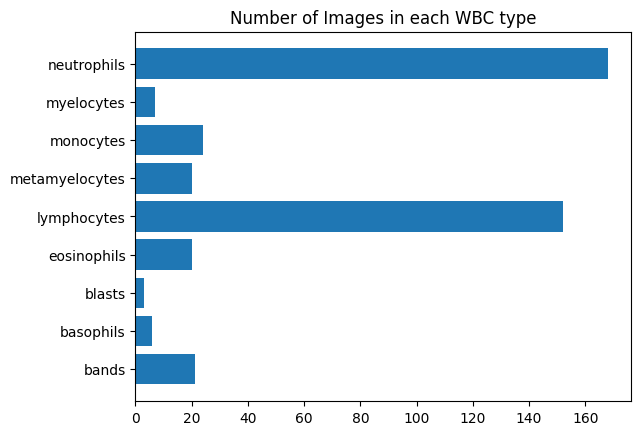

In [ ]:
# plot the number of images in each sub-folder of the train dataset

y_train_unique_counts = np.unique(y_train, return_counts=True)

plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()


### Observations:

1. This is an imbalanced dataset.
2. neutrophils is the majority class with 168 image samples.
3. blasts has the least number of samples: only 3 samples.
4. myelocytes and basophils have only 7 and 6 samples respectively.

Hence, there is a need to treat the imbalance of the train dataset.

There are a number of ways to deal with data imbalance:

1. Under-sampling the over-represented class. However, this can result in a loss of big amounts of useful data.

2. Over-sampling the under-represented class. There is big discrepancy in the counts between the classes such as neutrophils (168 samples) and blasts (3 samples).

SMOTE (Synthetic Minority Oversampling Technique). This method selects examples of data in the feature space (a data point and its nearest neighbor), and then creates a synthetic data point in-between them. In essence, this is an augmentation technique to add varying copies of existing data. We chose to go with this option since we do not want to lose data and do not want to experience the effects of over-fitting.

###Note:

If SMOTE is applied before augmentation on the given dataset, there is a restriction.

The class blasts has only 3 samples in the train dataset. Since, SMOTE works using the KNN algorithm, each image in the class blast has only 2 neighbours. This will create similar types of images in the classes that have very few images.

Therefore, applying SMOTE after image augmentation will create more variations.

## Augment the train dataset

###Note:

The number of new variations created by augmentation is limited by the computing resources (System RAM = 12.7 GB) provided in Colab notebook.

In [ ]:
# getting the image arrays associated with each class type in the train dataset

basophils_samples = X_train[np.where(y_train == 'basophils')]
bands_samples = X_train[np.where(y_train == 'bands')]
blasts_samples = X_train[np.where(y_train == 'blasts')]
eosinophils_samples = X_train[np.where(y_train == 'eosinophils')]
lymphocytes_samples = X_train[np.where(y_train == 'lymphocytes')]
monocytes_samples = X_train[np.where(y_train == 'monocytes')]
metamyelocytes_samples = X_train[np.where(y_train == 'metamyelocytes')]
myelocytes_samples = X_train[np.where(y_train == 'myelocytes')]
neutrophils_samples = X_train[np.where(y_train == 'neutrophils')]


In [ ]:
# using ImageDataGenerator to define new variations

datagen = ImageDataGenerator(
    rotation_range=20,
    fill_mode='constant',
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2
)


In [ ]:
# saving the new variations to their respective folders in the train dataset

basophils_generator = datagen.flow(
        basophils_samples,
        y_train[np.where(y_train == 'basophils')],
        save_to_dir = BASE_DIR + '/train/basophils',
        batch_size=1)

bands_generator = datagen.flow(
        bands_samples,
        y_train[np.where(y_train == 'bands')],
        save_to_dir = BASE_DIR + '/train/bands',
        batch_size=1)

blasts_generator = datagen.flow(
        blasts_samples,
        y_train[np.where(y_train == 'blasts')],
        save_to_dir = BASE_DIR + '/train/blasts',
        batch_size=1)

eosinophils_generator = datagen.flow(
        eosinophils_samples,
        y_train[np.where(y_train == 'eosinophils')],
        save_to_dir = BASE_DIR + '/train/eosinophils',
        batch_size=1)

lymphocytes_generator = datagen.flow(
        lymphocytes_samples,
        y_train[np.where(y_train == 'lymphocytes')],
        save_to_dir = BASE_DIR + '/train/lymphocytes',
        batch_size=1)

monocytes_generator = datagen.flow(
        monocytes_samples,
        y_train[np.where(y_train == 'monocytes')],
        save_to_dir = BASE_DIR + '/train/monocytes',
        batch_size=1)

metamyelocytes_generator = datagen.flow(
        metamyelocytes_samples,
        y_train[np.where(y_train == 'metamyelocytes')],
        save_to_dir = BASE_DIR + '/train/metamyelocytes',
        batch_size=1)

myelocytes_generator = datagen.flow(
        myelocytes_samples,
        y_train[np.where(y_train == 'myelocytes')],
        save_to_dir = BASE_DIR + '/train/myelocytes',
        batch_size=1)

neutrophils_generator = datagen.flow(
        neutrophils_samples,
        y_train[np.where(y_train == 'neutrophils')],
        save_to_dir = BASE_DIR + '/train/neutrophils',
        batch_size=1)


###Note:

82 is chosen in the following code cell as the number of new images created for each class of the train data due the limitations of the computational resources in the free version of the Colab notebook

lots of times session got expired during modelling because the system RAM provided in Colab notebook got exhausted

In [ ]:
# creating new variations in the train dataset

# 82 is used to create total of 250 images of the mojority class which is neutrophils
# neutrophils has total 168 images before augmentation
# hence, after augmentation, neutrophils will have total 168 + 82 = 250 images

for i in range(82):
    next(basophils_generator)
    next(bands_generator)
    next(blasts_generator)
    next(eosinophils_generator)
    next(lymphocytes_generator)
    next(monocytes_generator)
    next(metamyelocytes_generator)
    next(myelocytes_generator)
    next(neutrophils_generator)


In [ ]:
datagen_simple = ImageDataGenerator()


In [ ]:
basophils_test_samples = X_test[np.where(y_test == 'basophils')]
bands_test_samples = X_test[np.where(y_test == 'bands')]
blasts_test_samples = X_test[np.where(y_test == 'blasts')]
eosinophils_test_samples = X_test[np.where(y_test == 'eosinophils')]
lymphocytes_test_samples = X_test[np.where(y_test == 'lymphocytes')]
monocytes_test_samples = X_test[np.where(y_test == 'monocytes')]
metamyelocytes_test_samples = X_test[np.where(y_test == 'metamyelocytes')]
myelocytes_test_samples = X_test[np.where(y_test == 'myelocytes')]
neutrophils_test_samples = X_test[np.where(y_test == 'neutrophils')]


In [ ]:
basophils_test_generator = datagen_simple.flow(
        basophils_test_samples,
        y_test[np.where(y_test == 'basophils')],
        save_to_dir = BASE_DIR + '/test/basophils',
        batch_size=1)

bands_test_generator = datagen_simple.flow(
        bands_test_samples,
        y_test[np.where(y_test == 'bands')],
        save_to_dir = BASE_DIR + '/test/bands',
        batch_size=1)

blasts_test_generator = datagen_simple.flow(
        blasts_test_samples,
        y_test[np.where(y_test == 'blasts')],
        save_to_dir = BASE_DIR + '/test/blasts',
        batch_size=1)

eosinophils_test_generator = datagen_simple.flow(
        eosinophils_test_samples,
        y_test[np.where(y_test == 'eosinophils')],
        save_to_dir = BASE_DIR + '/test/eosinophils',
        batch_size=1)

lymphocytes_test_generator = datagen_simple.flow(
        lymphocytes_test_samples,
        y_test[np.where(y_test == 'lymphocytes')],
        save_to_dir = BASE_DIR + '/test/lymphocytes',
        batch_size=1)

monocytes_test_generator = datagen_simple.flow(
        monocytes_test_samples,
        y_test[np.where(y_test == 'monocytes')],
        save_to_dir = BASE_DIR + '/test/monocytes',
        batch_size=1)

metamyelocytes_test_generator = datagen_simple.flow(
        metamyelocytes_test_samples,
        y_test[np.where(y_test == 'metamyelocytes')],
        save_to_dir = BASE_DIR + '/test/metamyelocytes',
        batch_size=1)

myelocytes_test_generator = datagen_simple.flow(
        myelocytes_test_samples,
        y_test[np.where(y_test == 'myelocytes')],
        save_to_dir = BASE_DIR + '/test/myelocytes',
        batch_size=1)

neutrophils_test_generator = datagen_simple.flow(
        neutrophils_test_samples,
        y_test[np.where(y_test == 'neutrophils')],
        save_to_dir = BASE_DIR + '/test/neutrophils',
        batch_size=1)


In [ ]:
for i in range(len(basophils_test_samples)):
    next(basophils_test_generator)

for i in range(len(bands_test_samples)):
    next(bands_test_generator)

for i in range(len(blasts_test_samples)):
    next(blasts_test_generator)

for i in range(len(eosinophils_test_samples)):
    next(eosinophils_test_generator)

for i in range(len(lymphocytes_test_samples)):
    next(lymphocytes_test_generator)

for i in range(len(monocytes_test_samples)):
    next(monocytes_test_generator)

for i in range(len(metamyelocytes_test_samples)):
    next(metamyelocytes_test_generator)

for i in range(len(myelocytes_test_samples)):
    next(myelocytes_test_generator)

for i in range(len(neutrophils_test_samples)):
    next(neutrophils_test_generator)


## Load the augmented training dataset

to analyse the class distribution after augmentation



In [ ]:
# using the get_data method defined earlier to load the augmented training data

X_train, y_train = get_data(BASE_DIR + '/train')
X_test, y_test = get_data(BASE_DIR + '/test')


In [ ]:
# summarize the new class distribution in the augmented train dataset

counter = Counter(y_train)
print(counter)


Counter({'neutrophils': 250, 'lymphocytes': 234, 'monocytes': 106, 'bands': 103, 'eosinophils': 102, 'metamyelocytes': 102, 'myelocytes': 89, 'basophils': 88, 'blasts': 84})


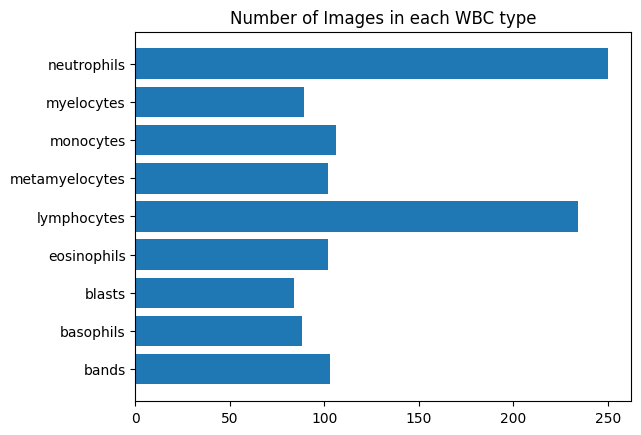

In [ ]:
# visualize the new class distribution the augmented train dataset

y_train_unique_counts = np.unique(y_train, return_counts=True)

plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()


# Continued in the next notebook

due to the computational resource limitation (System RAM = 12.7 GB) in the free version of Colab notebooks